## BDAT 1010-04 Assignment 1 - Machine Learning

## Group 9 Shubham Chawla (200493036), Archit Sinha (200505416), Chintan Piyush Vajani (200508118)

## 1. Dataset Information

URL: https://catalog.data.gov/dataset/consumer-complaint-database

The dataset contains information about consumer complaints regarding financial services and products, such as student loans, credit reports, mortgage etc. in the US from December 1, 2011 to July 5, 2022. Each complaint belongs to a Product Category. 
We will be using supervised learning techniques to predict the correct category of the complaint by using text classification algorithm with the text (complaint from the consumer) as the input.
An automated system that can identify a complaint category by analyzing the complaint itself which is the user/client input is very important in a company that has to deal with thousands of complaints on a daily basis.

## Importing necessary libraries

In [1]:
#importing required libraries

from sklearn.feature_extraction.text import TfidfVectorizer
import sklearn.feature_extraction.text as text
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

import nltk
from nltk.stem import PorterStemmer,SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.tokenize.toktok import ToktokTokenizer

#import gensim
#from gensim.models import Word2Vec
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import re
nltk.download('stopwords')
nltk.download('wordnet')
tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english') 
import warnings
warnings.filterwarnings("ignore")

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm, tqdm_notebook

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\shubh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\shubh\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
#Import the dataset
comp_df = pd.read_csv("consumer_complaints.csv")

In [3]:
comp_df[['Product','Consumer complaint narrative']].tail(5)

,Product,Consumer complaint narrative
2773551,Debt collection,I have disputed my debts several times with no...
2773552,Mortgage,My father died in XX/XX/XXXX. Left me his only...
2773553,Credit reporting,cfbp i would Like to file a complaint on Exper...
2773554,Credit reporting,My husband and I are in the middle of an FHA S...
2773555,Mortgage,NaN


## 2. Data preparation

In [4]:
# Checking Dataset size
comp_df.shape

(2773556, 18)

In [5]:
# Checking columns
comp_df.columns

Index(['Date received', 'Product', 'Sub-product', 'Issue', 'Sub-issue',
       'Consumer complaint narrative', 'Company public response', 'Company',
       'State', 'ZIP code', 'Tags', 'Consumer consent provided?',
       'Submitted via', 'Date sent to company', 'Company response to consumer',
       'Timely response?', 'Consumer disputed?', 'Complaint ID'],
      dtype='object')

In [6]:
# Converting date column to date format for filtering our dataset later by date
comp_df['Date received'] = pd.to_datetime(comp_df['Date received'])

# Get the year in which the complaint took place as a separate column
comp_df['Year'] = comp_df['Date received'].apply(lambda date: date.year)

In [8]:
# Checking number of complaints for each year
comp_df.groupby(['Year'])['Consumer complaint narrative'].count()

Year
2011         0
2012         0
2013         0
2014         0
2015     54751
2016     77818
2017    115166
2018    118462
2019    124885
2020    174358
2021    203599
2022    111957
Name: Consumer complaint narrative, dtype: int64

### Reducing Data Size and imbalance in the dataset
The dataset is quite big in size (close to 1.8GB) as it is updated regularly. Due to less resources we will be reducing the size of our dataset, we will be working with a subset of the data ranging from date July 05, 2021 to July 5, 2022, i.e. almost an year worth of complaint data with around 607K complaints

In [9]:
# Reducing size
comp_df = comp_df[(comp_df['Date received'] >= '2021-07-05') & (comp_df['Date received'] <= '2022-07-05')]

In [10]:
comp_df.shape

(607201, 19)

In [12]:
## Combining Loans together to reduce redundancy
comp_df.replace('Student loan', 'Loan', inplace=True)
comp_df.replace('Vehicle loan or lease', 'Loan', inplace=True)
comp_df.replace('Payday loan, title loan, or personal loan', 'Loan', inplace=True)
# Replacing product category text with smaller keyword
comp_df['Product'] = comp_df['Product'].str.replace('Credit reporting, credit repair services, or other personal consumer reports','Credit Reporting')
comp_df['Product'] = comp_df['Product'].str.replace('Money transfer, virtual currency, or money service','Money Service')

In [13]:
# Reducing Credit Reporting Category by 90% as it is creating an imbalance in the dataset
percentage_reduction = 0.9

# Debt Collection Reduction
comp_df = \
comp_df.drop(
    comp_df[comp_df['Product'] == 
            'Credit reporting, credit repair services, or other personal consumer reports'].sample(frac=percentage_reduction).index)

### Checking Number of Complaints by Product Category

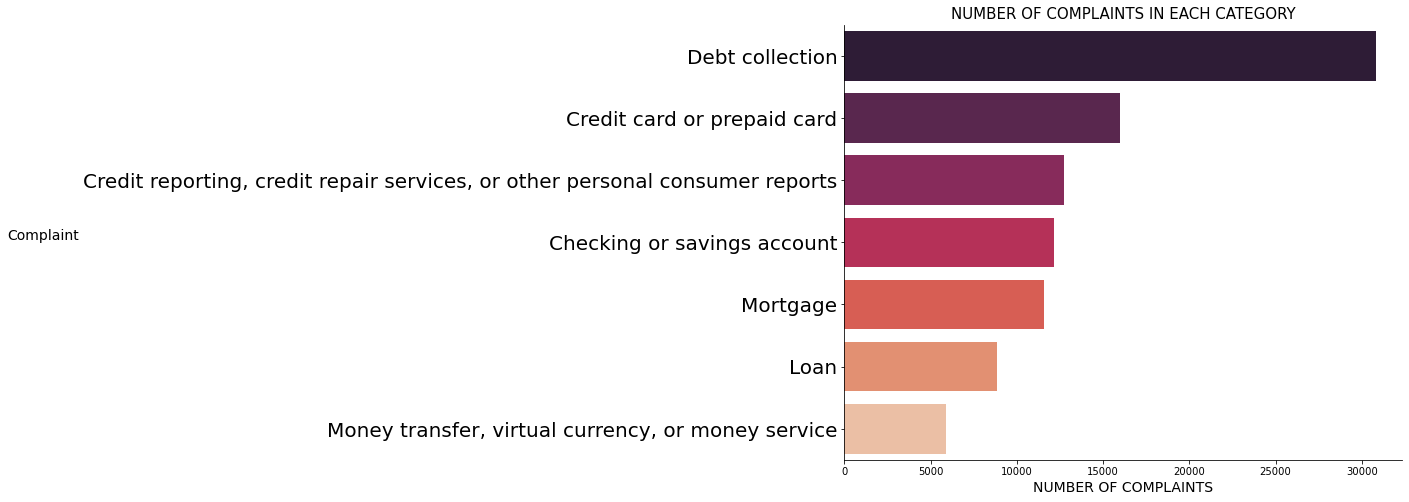

In [77]:
fig, ax = plt.subplots(figsize=(10,8))

ax = sns.countplot(y='Product', 
                   data=comp_df, 
                   order=comp_df['Product'].value_counts().index,
                   palette='rocket'       
                  )

ax.set_title('NUMBER OF COMPLAINTS IN EACH CATEGORY',size=15)

# Setting labels
# Dealing with y-labels
ax.set_ylabel('Complaint', rotation=0, labelpad=40, size=14)
plt.yticks(fontsize=20)             
# Dealing with x-labels
ax.set_xlabel('NUMBER OF COMPLAINTS', size=14)

sns.despine()
plt.savefig('freq_of_removed_classes_and_reduced_observations.png', transparency=True)

We can see some class imbalance as the Credit Reporting category seems to be dominating the data across all four years which we have taken into consideration.

In [17]:
#Renaming Consumer complaint narrative to Complaint for ease of use
comp_df.rename(columns={'Consumer complaint narrative': 'Complaint'}, inplace=True)
# checking null values 
comp_df.isnull().sum()

Date received                        0
Product                              0
Sub-product                          0
Issue                                0
Sub-issue                        40748
Complaint                       129001
Company public response         135363
Company                              0
State                             2020
ZIP code                          2061
Tags                            195959
Consumer consent provided?       51825
Submitted via                        0
Date sent to company                 0
Company response to consumer         0
Timely response?                     0
Consumer disputed?              226969
Complaint ID                         0
Year                                 0
dtype: int64

In [19]:
# Removing null values from our target column while retaining nulls in other columns
comp_df = comp_df[pd.notnull(comp_df['Complaint'])]
comp_df.shape

(97968, 19)

### Number of complaints after data cleaning - 97.9K complaints

In [20]:
# Retaining required columns for our analysis
col = ['Year', 'Complaint', 'Product']
comp_df = comp_df[col]

In [21]:
comp_df.head(5)

,Year,Complaint,Product
10,2022,I set up a recurring scheduled payment on my c...,Checking or savings account
19,2022,Bank of america is a very reputable bank and h...,"Credit reporting, credit repair services, or o..."
30,2022,ATTN Fraud Department : Remove fraudulent acco...,"Credit reporting, credit repair services, or o..."
36,2022,"Please reopen case XXXX, Nothing has been reso...",Credit card or prepaid card
38,2022,Was not aware of the XXXX XXXX that was placed...,Debt collection


### Text Data Preprocessing 

In [23]:
#Converting Text data to lowercase
comp_df['Complaint'] = comp_df['Complaint'].str.lower()
# Checking text case
comp_df['Complaint'].head(2)

10    i set up a recurring scheduled payment on my c...
19    bank of america is a very reputable bank and h...
Name: Complaint, dtype: object

In [24]:
# Removing punctuations
comp_df['Complaint'] = comp_df['Complaint'].str.replace(r'[^\w\s]',"")
# Removing ambiguous characters
comp_df['Complaint'] = comp_df['Complaint'].str.replace(r"xx+\s","")
# Checking text
comp_df['Complaint'].head(2)

10    i set up a recurring scheduled payment on my c...
19    bank of america is a very reputable bank and h...
Name: Complaint, dtype: object

In [26]:
# Removing stopwords
from nltk.corpus import stopwords
stop = stopwords.words('english')
comp_df['Complaint'] =comp_df['Complaint'].apply(lambda x: ' '.join([i for i in x.split() if i not in stop]))
comp_df['Complaint'].head(2)

10    set recurring scheduled payment checking accou...
19    bank america reputable bank long time covid19 ...
Name: Complaint, dtype: object

## 3. Dimesionality Reduction - Latent Semantic Analysis

In [27]:
stopword_list = stopwords.words('english')
dtm = CountVectorizer(max_df=0.7, min_df=5, token_pattern="[a-z']+", 
                      stop_words=stopword_list, max_features=2000) # Only top 2000 most frequently ocurring words are considered
dtm.fit(comp_df['Complaint'])
dtm_mat = dtm.transform(comp_df['Complaint'])

In [28]:
tsvd = TruncatedSVD(n_components=200)
tsvd.fit(dtm_mat)
tsvd_mat = tsvd.transform(dtm_mat)
s_list = []
for clus in tqdm(range(2,21)):
    
    km = KMeans(n_clusters=clus, n_init=50, max_iter=1000) # Instantiate KMeans clustering

    km.fit(tsvd_mat) # Run KMeans clustering

    s = silhouette_score(tsvd_mat, km.labels_)
    
    s_list.append(s)

100%|█████████████████████████████████████████████████████████████████████████████████| 19/19 [52:30<00:00, 165.80s/it]


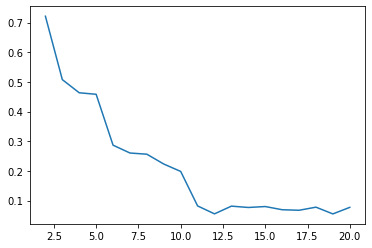

In [29]:
plt.plot(range(2,21), s_list)
plt.show()

The plot shows clearly that the silhouette scores are quite low. Thus, either the clusters are not linearly separable or there is a considerable amount of overlaps among them. A TSNE plot is better suited in such a case. The TSNE plot extracts a low dimensional representation of high dimensional data through a non-linear embedding method which tries to retain the local structure of the data. 

In [30]:
tsne = TSNE(n_components=2)
tsne_mat = tsne.fit_transform(tsvd_mat)

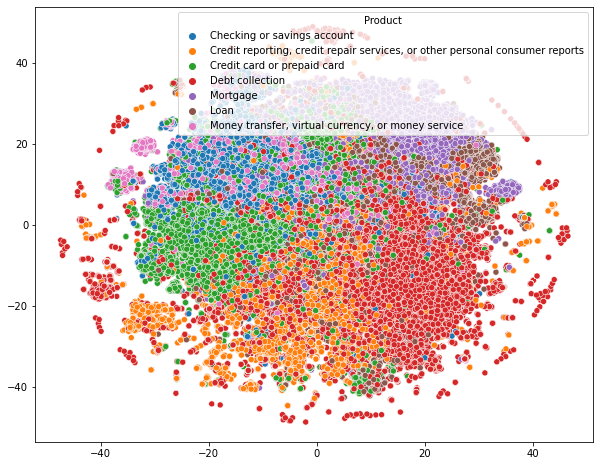

In [35]:
plt.figure(figsize=(10,8))
sns.scatterplot(tsne_mat[:,0],tsne_mat[:,1],hue=comp_df['Product'])
plt.show()

Credit Reporting Category shows a much wider spread whereas other product categories look quite nicely clustered. It suggests that LSA (or Truncated SVD) has done a good job on the textual data to extract 200 important dimensions to segregate complaints on different product categories.

### Creating word cloud for words appearing more often in Complaints for each product category

Checking or savings account


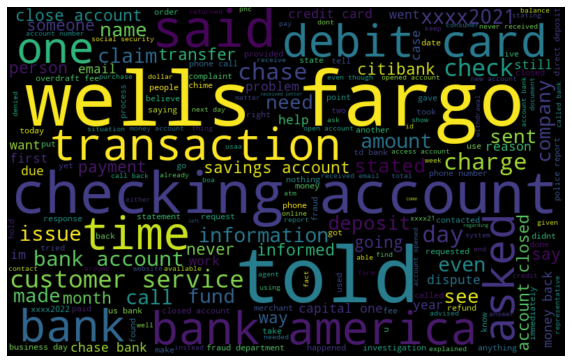

Credit reporting, credit repair services, or other personal consumer reports


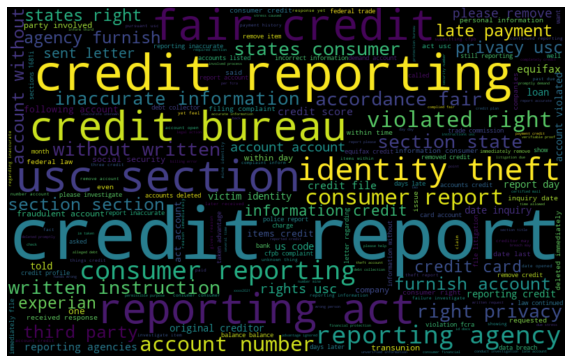

Credit card or prepaid card


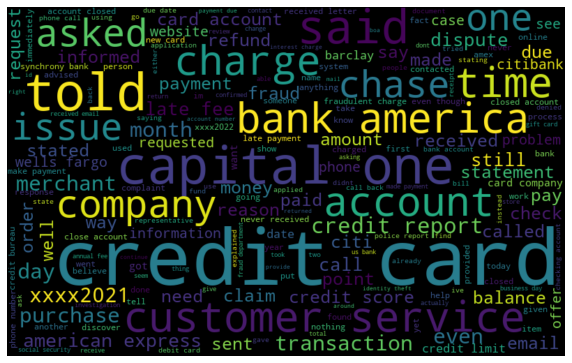

Debt collection


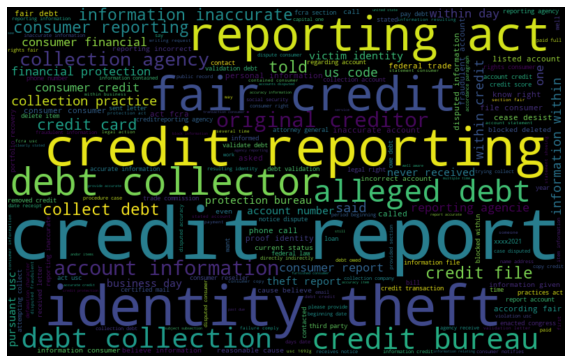

Mortgage


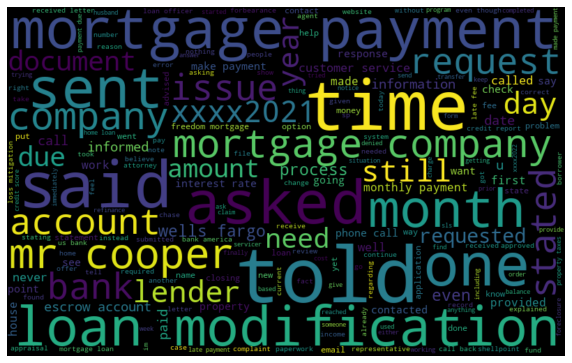

Loan


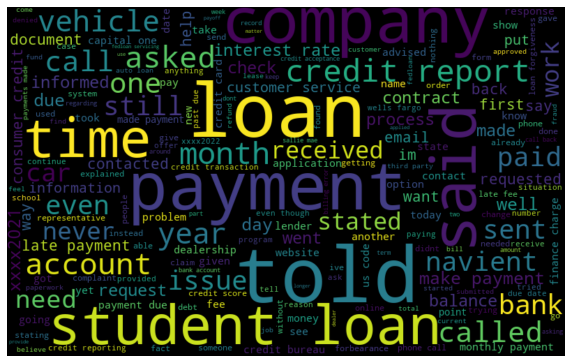

Money transfer, virtual currency, or money service


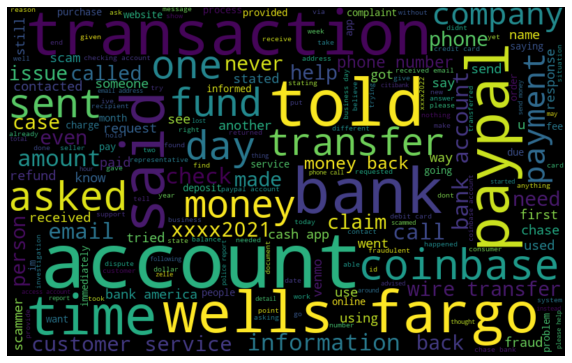

In [36]:
##!pip install wordcloud
for product_name in comp_df['Product'].unique():
    print(product_name)
    all_words = ' '.join([text for text in comp_df.loc[comp_df['Product'].str.contains(product_name),'Complaint']])
    from wordcloud import WordCloud
    wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()

## Vectorization

To turn words into something a machine learning algorithm can understand and process, is called Vectorization. Here we have used TF-IDF approach which looks at the number of times a word appears in a complaint relative to the number of times it appears in other complaints.
Two things result in a higher TF-IDF score:

Higher frequency of the word within the specific complaint being scored.
Lower frequency of the word across all other complaints.

In [37]:
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern='\w{1,}', max_features=5000)
tfidf_vect.fit(comp_df['Complaint'])
Features = tfidf_vect.transform(comp_df['Complaint'])

encoder = preprocessing.LabelEncoder()
Labels1 = encoder.fit_transform(comp_df['Product']) # defining labels

The original data was divided into features (X) and target (Y), which were then splitted into the train (75%) and test (25%) sets. Thus, the algorithms would be trained on one set of data and tested out on a completely different set of data (not seen before by the algorithm).

In [38]:
# splitting test and train data - by default it splits it into 25:75 ratio
train_x, valid_x,  train_y, valid_y = train_test_split(comp_df['Complaint'],comp_df['Product']) 

In [43]:
encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(train_y)
valid_y = encoder.fit_transform(valid_y)
#print(train_y)

tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern='\w{1,}', max_features=5000)  

tfidf_vect.fit(comp_df['Complaint'])
#print(tfidf_vect.stop_words) # printing stop words
#print(tfidf_vect.vocabulary_) # printing vocabulary
xtrain_tfidf = tfidf_vect.transform(train_x)
#print(xtrain_tfidf)
xvalid_tfidf = tfidf_vect.transform(valid_x)

## 4. MultiClass Text Classification Logistic Regression Model to predict complaint category

### Model Building

We are using logistic regression here for text classification as this technique is used to make predictions to find the value of a dependent variable which is Complaint in our case. We will be using Multinominal Logistic Regression as it deals with cases when the target or independent variable has three or more possible values. In our case we have 7 such Product Categories to which our complaints (text) will be classified.

In [44]:
# Building our Model
model = linear_model.LogisticRegression().fit(xtrain_tfidf, train_y)
model

LogisticRegression()

In [45]:
# checking accuracy
accuracyLogistic = metrics.accuracy_score(model.predict(xvalid_tfidf),valid_y)

print("Accuracy: ",accuracyLogistic)
print(metrics.classification_report(valid_y,model.predict(xvalid_tfidf), target_names=comp_df['Product'].unique()))

Accuracy:  0.8310060427894823
                                                                              precision    recall  f1-score   support

                                                 Checking or savings account       0.78      0.83      0.80      3071
Credit reporting, credit repair services, or other personal consumer reports       0.80      0.82      0.81      4017
                                                 Credit card or prepaid card       0.83      0.76      0.79      3236
                                                             Debt collection       0.85      0.89      0.87      7612
                                                                    Mortgage       0.79      0.72      0.75      2212
                                                                        Loan       0.79      0.71      0.75      1465
                          Money transfer, virtual currency, or money service       0.93      0.92      0.93      2879

                        

We have achieved an accuracy of around 83% with a Logistic Regression model and the classification metrics are overall good for all departments except Checking or Savings Account,Mortgage and Loan - this might be due to less training instances of this product category and also on looking at the confusion matrix it is mostly being predicted as Credit reporting or debt collection which gives us an indication that this product is similar to one another or maybe linked with other.

### Applying Random Forest Classifier, LinearSVC and MultinomialNB

In [47]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(comp_df['Complaint'], comp_df['Product'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [48]:
# 
print(clf.predict(count_vect.transform(["This company refuses to provide me verification and validation of debt per my right under the FDCPA. I do not believe this debt is mine."])))

['Debt collection']


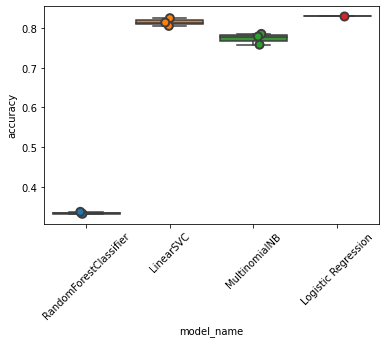

In [59]:
models = [RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
          LinearSVC(),
          MultinomialNB(),
]
CV = 3
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, Features, Labels1, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

# Appending Accuracy record for Logisitic regression model
df2 = {'model_name': 'Logistic Regression', 'fold_idx': '0', 'accuracy': accuracyLogistic} 
cv_df = cv_df.append(df2, ignore_index = True)

import seaborn as sns

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.xticks(rotation=45)
plt.show()

In [62]:
cv_df.groupby('model_name', as_index=False).agg({"accuracy": "mean"})

,model_name,accuracy
0,LinearSVC,0.815572
1,Logistic Regression,0.831006
2,MultinomialNB,0.774661
3,RandomForestClassifier,0.333211


#### We can see our first model logistic regression has the highest accuracy here with 83% followed by LinearSVC with 81.5%.

#### Evaluating performance of logistic regression model

In [63]:
model = linear_model.LogisticRegression().fit(xtrain_tfidf, train_y)
model
confusion_matrix = metrics.confusion_matrix(valid_y,model.predict(xvalid_tfidf))
print(confusion_matrix)

[[2539  260    7   50   21  180   14]
 [ 275 3284  104  236   56   51   11]
 [  16  120 2463  517   74    1   45]
 [  55  202  284 6792  188   27   64]
 [  43  131   86  315 1583    8   46]
 [ 282   78    2   31   18 1043   11]
 [  31   36   26   71   60    6 2649]]


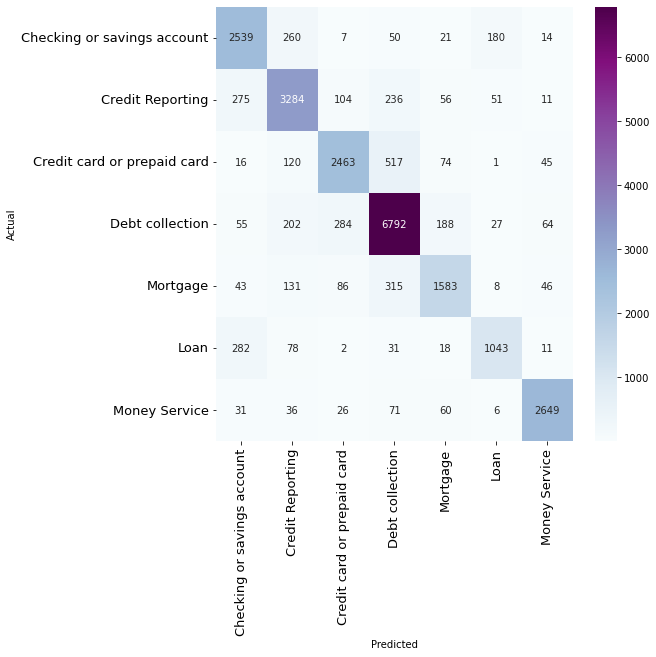

In [101]:
# Heatmap displaying Confusion Matrix 
def heat_conf():
    conf_mat = metrics.confusion_matrix(valid_y,model.predict(xvalid_tfidf))
    fig, ax = plt.subplots(figsize=(8,8))
    plt.yticks(fontsize=13)
    plt.xticks(fontsize=13)
    sns.heatmap(conf_mat, annot=True,fmt='d',cmap='BuPu',xticklabels=comp_df['Product'].unique(),yticklabels=comp_df['Product'].unique())
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    
heat_conf()

The confusion matrix shows the following characteristics; All cases are classified reasonably well however the Mortgage and Loan are not classified accurately.

## Checking our model

In [102]:
category_id_df = pd.DataFrame()
category_id_df['category'] = comp_df['Product'].unique()
category_id_df['category_id'] = category_id_df.index.values

#print(category_id_df.index.values)
category_to_id = dict(category_id_df[['category_id','category']].values)
category_to_id

{0: 'Checking or savings account',
 1: 'Credit Reporting',
 2: 'Credit card or prepaid card',
 3: 'Debt collection',
 4: 'Mortgage',
 5: 'Loan',
 6: 'Money Service'}

In [126]:
pd.set_option('display.max_colwidth', -1)
comp_df.head(2)

,Year,Complaint,Product
10,2022,set recurring scheduled payment checking account bank america mom assisted living home amount 1000000 xxxx2022 xxxx2022 received notice payment scheduled would mailed xxxx2022 received call regarding mother needed see received call unknown number ignored since mother important thought another spam call voicemail left stating needed contact fraud dept pay check message already past time gave call back 1 set payment xxxx2022 afraid fraud wasnt contacted sure wanted send scheduled payment amount 1000000 every month 2 indication bank america calling would answered 3 would call leave message stating call back pay item message left clearly bank error requested pay item stated would resubmitted course gets returned item bank returned item fee requested bank america give letter stating made error returning check reimburse payee returned item fee bank refused way get check paid authorized 10 days check presented check bank america mailed way scenario going cause customer harm first please examine procedures wrong many ways,Checking or savings account
19,2022,bank america reputable bank long time covid19 definitely change customer service dealing customers day day basis many problems credit card unable help credit score dropped points experiencing many hardships unable help reached many many times got weak excuse need fix credit report,Credit Reporting


In [113]:
text1 = ['''set recurring scheduled payment checking account bank america mom assisted living home amount 1000000 xxxx2022 xxxx2022 received notice payment scheduled would mailed xxxx2022 received call regarding mother needed see received call unknown number ignored since mother important thought another spam call voicemail left stating needed contact fraud dept pay check message already past time gave call back 1 set payment xxxx2022 afraid fraud wasnt contacted sure wanted send scheduled payment amount 1000000 every month 2 indication bank america calling would answered 3 would call leave message stating call back pay item message left clearly bank error requested pay item stated would resubmitted course gets returned item bank returned item fee requested bank america give letter stating made error returning check reimburse payee returned item fee bank refused way get check paid authorized 10 days check presented check bank america mailed way scenario going cause customer harm first please examine procedures wrong many ways''']
text_features = tfidf_vect.transform(text1)
predictions = model.predict(text_features)
# print(predictions)
print(texts)
print("   -Predicted as: {}".format(category_to_id[predictions[0]]))

['This account popped up on my credit and it is not mines. I have filled out all the correct docs to show that i am victim of identity thief and will attach the ftc report with this complaint. Please block and remove this from my credit please XXXX XXXX XXXX Account Number: XXXX XXXX / 2019']
   -Predicted as: Checking or savings account


In [119]:
text1 = ['''bank america reputable bank long time covid19 definitely change customer service dealing customers day day basis many problems credit card unable help credit score dropped points experiencing many hardships unable help reached many many times got weak excuse need fix credit report''']
text_features = tfidf_vect.transform(text1)
predictions = model.predict(text_features)
# print(predictions)
print(texts)
print("   -Predicted as: {}".format(category_to_id[predictions[0]]))

['This account popped up on my credit and it is not mines. I have filled out all the correct docs to show that i am victim of identity thief and will attach the ftc report with this complaint. Please block and remove this from my credit please XXXX XXXX XXXX Account Number: XXXX XXXX / 2019']
   -Predicted as: Credit Reporting


In [128]:
comp_df.to_csv('Complaints_Cleaned.csv')